# Wasserhaushalt von Stadtbäumen - Urban Tree

In diesem Notebook wird die Anwendung des Urban-Tree Modells zur Modellierung des Wasserhaushalts von Stadtbäumen vorgestellt. Benötigt werden tägliche Zeitreihen des Niederschlags und der Evapotranspiration, sowie eine Vielzahl von Baumparametern.
In der Studie wurden Bäume "zufällig" erstellt, um eine Vielzahl von möglichen unterschiedlichen Parameternkombinationen zu berücksichtigen.
Der Beispieldatensatz basiert auf täglichen Beobachtungswerten von 2018-2024 der DWD-Station Potsdam (ID:3987). Um den numerischen Fehler klein zu halten, wurde dieser tägliche Datensatz auf stündliche Daten heruntergerechnet (geteilt durch 24).

In [7]:
import pandas as pd
import urban_tree_model as ut
import numpy as np
import scipy

data = pd.read_csv("example_data_potsdam.csv")
data.date = pd.to_datetime(data.date)

### Erstellung eines zufällig parametrisierten mittelalten Baumes

In [2]:
tree = ut.Tree("medium")

print(f"Bodenart in Pflanzgrube: {tree.soil}")
print(f"Effektive Wurzeltiefe: {tree.rooting_depth} m")
print(f"Kronenfläche: {tree.cpa} m²")
print(f"Bodenwassergehalt: {round(tree.saw, 1)} mm")
print(f"Infiltrationskoeffizient: {tree.c_inf} mm")
print(f"Pflanzenspezifischer Verdunstungskoeffizient: {tree.kc}")
print(f"Trockenstresskoeffizient: {round(tree.k_ea, 1)}")
print(f"Trockenstressfaktor: {round(tree.k_s, 1)}")
print(f"Feldkapazität: {tree.fc} mm")
print(f"Versiegelungsgrad: {tree.surface_sealing}")
print(f"Versiegelungsart: {tree.sealing_class}")
print(f"Sky-View-Factor: {tree.sky_view_factor}")
print(f"Anfansgwassergehalt: {tree.start_water_content}")

Bodenart in Pflanzgrube: sandy_loam
Effektive Wurzeltiefe: 0.8 m
Kronenfläche: 36 m²
Bodenwassergehalt: 16.4 mm
Infiltrationskoeffizient: 22 mm
Pflanzenspezifischer Verdunstungskoeffizient: 0.62
Trockenstresskoeffizient: 0.4
Trockenstressfaktor: 0.2
Feldkapazität: 164.0 mm
Versiegelungsgrad: 0.65
Versiegelungsart: 4
Sky-View-Factor: 1.05
Anfansgwassergehalt: 0.55


### Wasserhaushalt des erstellten Baums ohne Bewässerung:

In [3]:
df = ut.urban_tree(data.et_pot.values, data.rain.values, data.date.values,
                   l_max=10, c_i=0.5, c_r=0.2, c_rt=10, c_inf=tree.c_inf,
                   k_c=tree.kc, k_ea=tree.k_ea, k_s=tree.k_s, fc=tree.fc, pwp=40,
                   crown_area=tree.cpa, surface_sealing=tree.surface_sealing, sealing_class=tree.sealing_class,
                   rooting_depth=tree.rooting_depth, start_water_content=tree.start_water_content,
                   cistern_volume=0, cistern_catchment=0, loss_factor_in=0.6, loss_factor_out=0.2,
                   irrigation_rate=0, sky_view_factor=tree.sky_view_factor)

#Aggregierung zu täglichen Daten
df.set_index("date", inplace=True)
et_a_daily = df.et_a_mm.resample("D").sum()
rain_daily = df.rain_mm.resample("D").sum()
swc_daily = df["soil_water_content_mm/m"].resample("d").mean()
water_stress_daily = df.water_stress.resample("d").mean().round(0)

print(f'Jährliches Mittel der Tage mit Trockenstress: {int(len(water_stress_daily[water_stress_daily ==2]) / 7)} Tage/Jahr')

Jährliches Mittel der Tage mit Trockenstress: 50 Tage/Jahr


#### Erstellung einer Abbildung

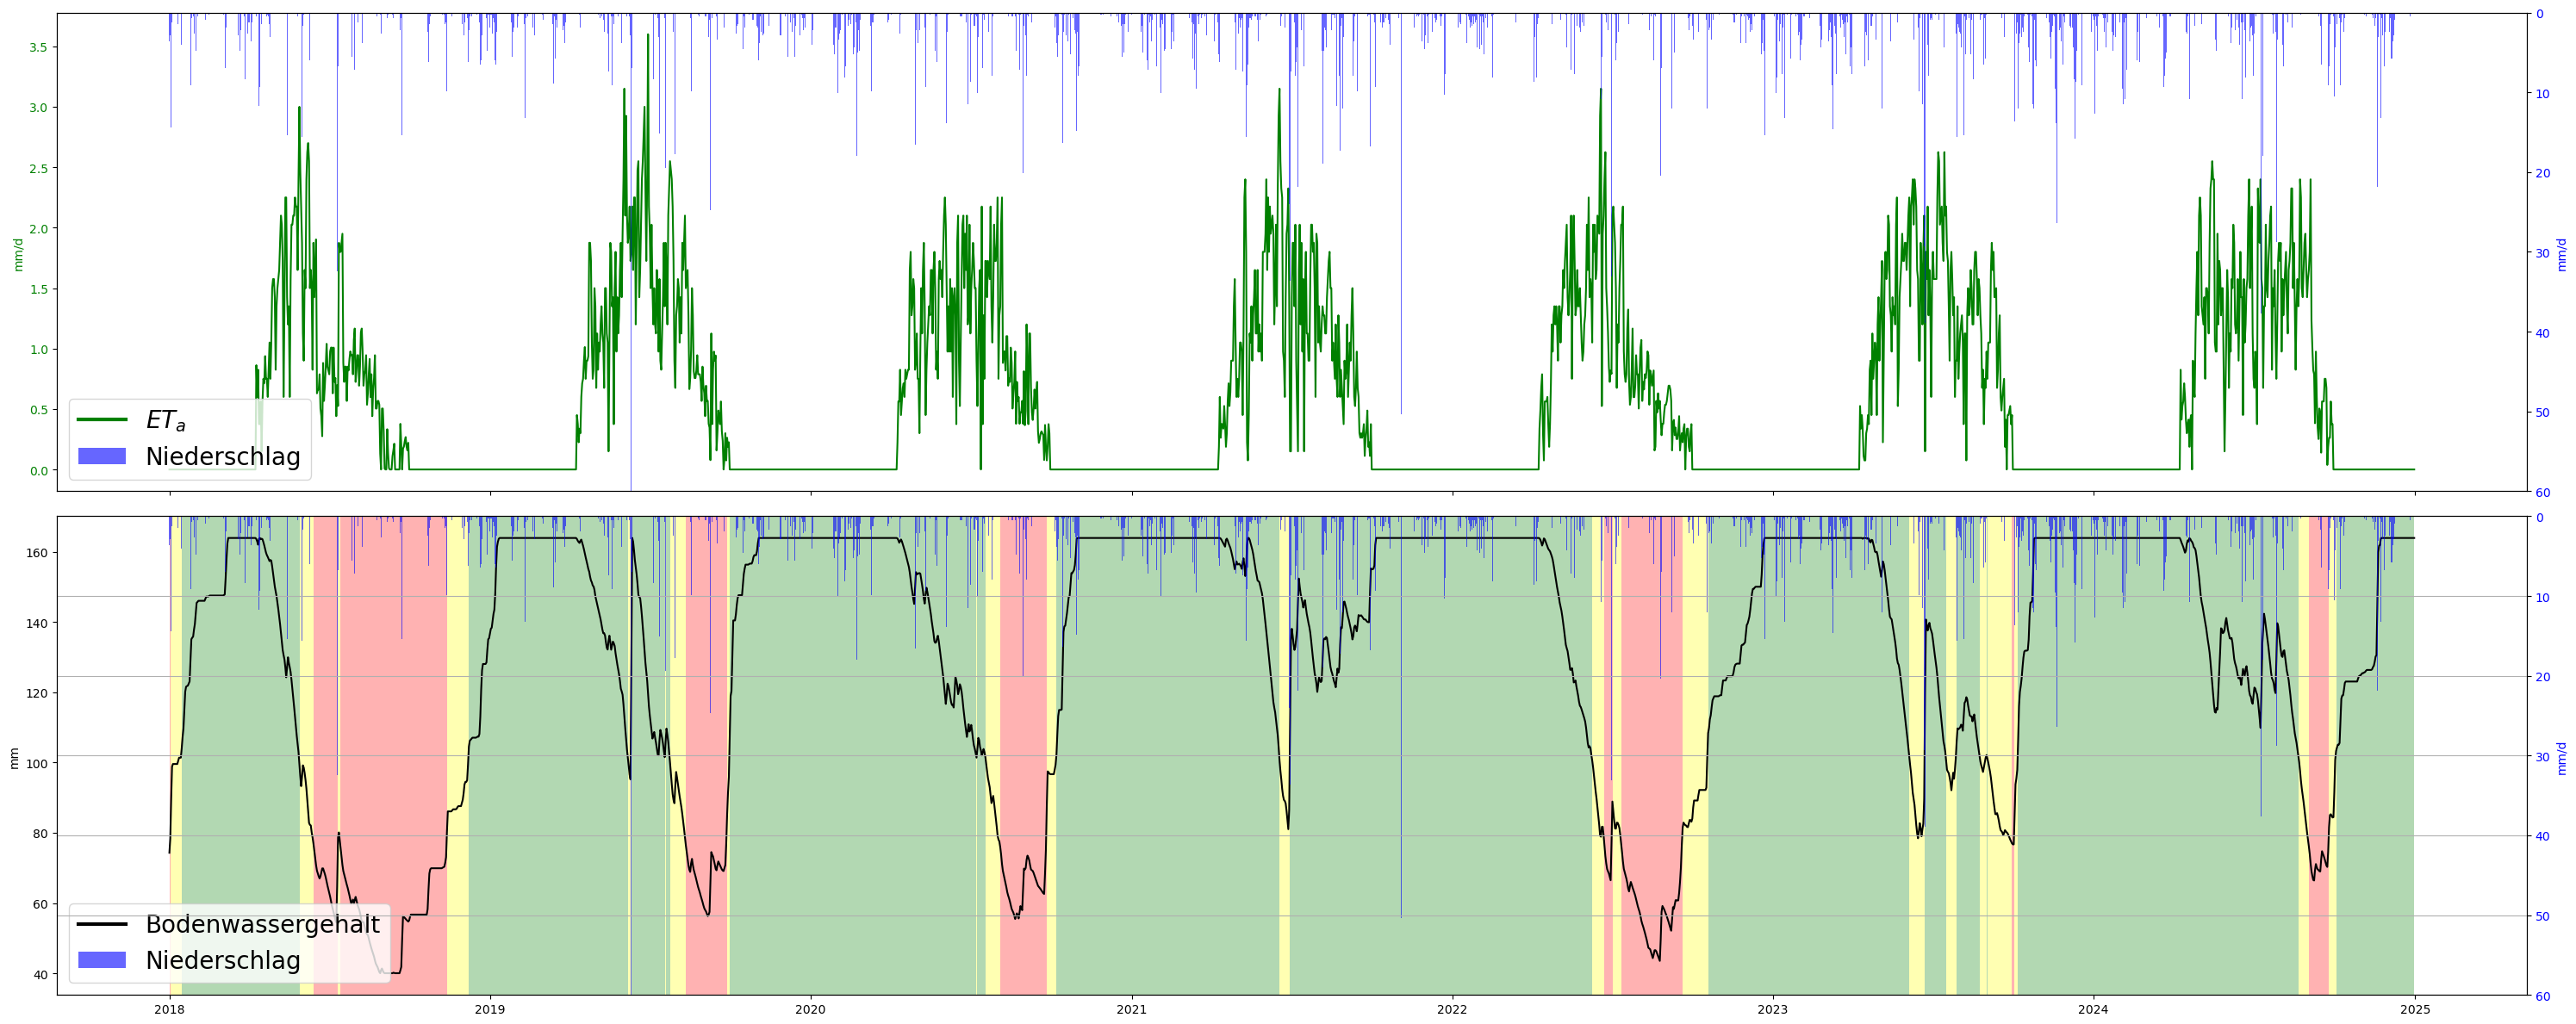

In [4]:
plot_df = pd.DataFrame({"rain":rain_daily, "et_a":et_a_daily, "soil_water_content":swc_daily,
                        "water_stress": water_stress_daily, "date":rain_daily.index})
ut.make_figure(plot_df)

### Wasserhaushalt des erstellten Baums mit Bewässerung:
Zisternengröße: 2.93 m³
Zisternenauffangfläche: 211 m²
Bewässerungsrate: 300l/Tag bei Wasserstress

Jährliches Mittel der Tage mit Trockenstress: 0 Tage/Jahr


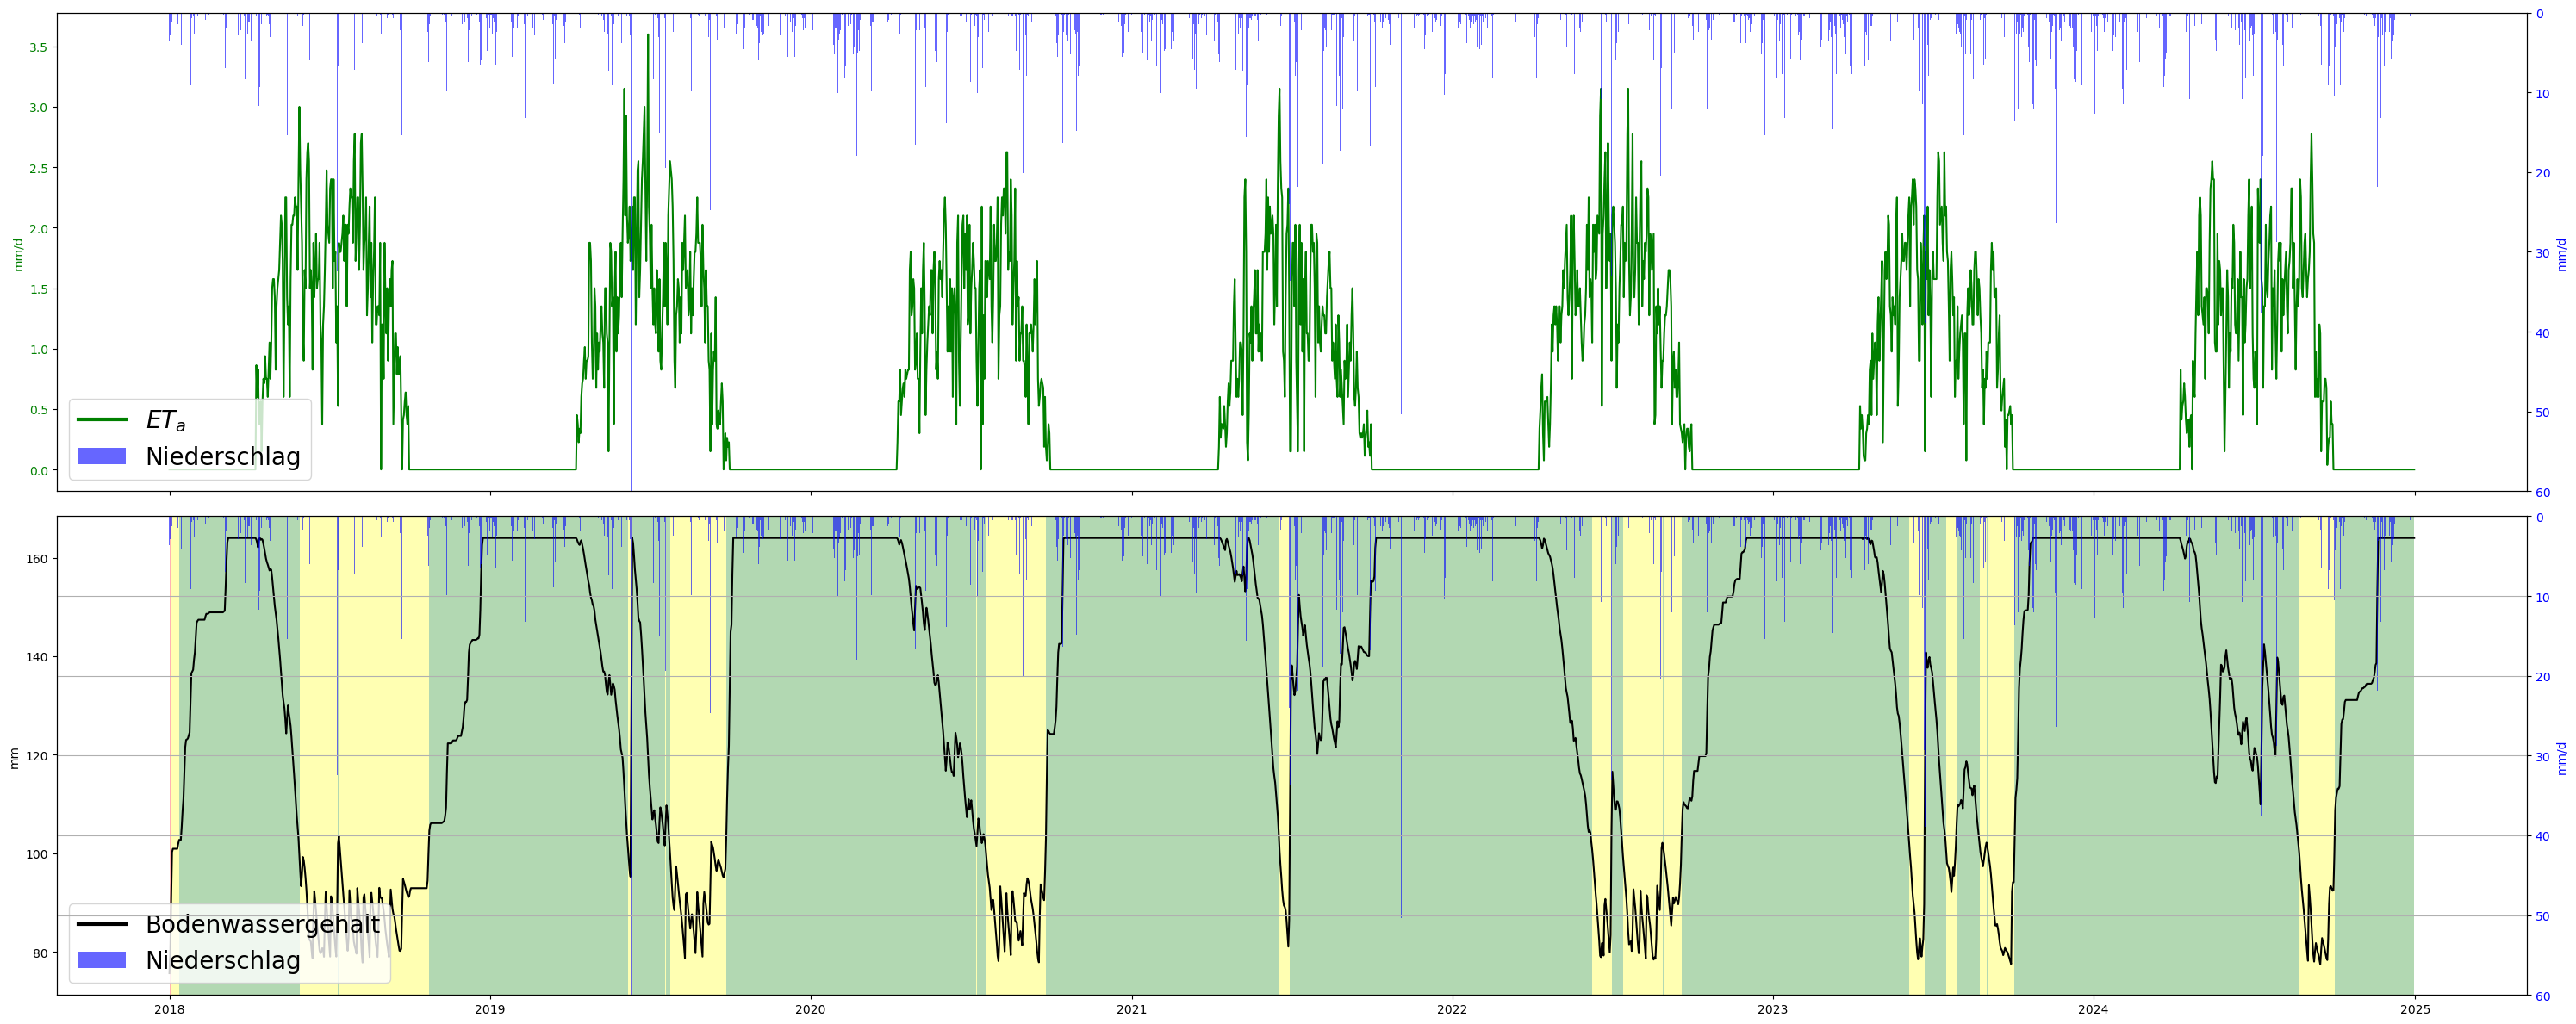

In [6]:
df = ut.urban_tree(data.et_pot.values, data.rain.values, data.date.values,
                   l_max=10, c_i=0.5, c_r=0.2, c_rt=10, c_inf=tree.c_inf,
                   k_c=tree.kc, k_ea=tree.k_ea, k_s=tree.k_s, fc=tree.fc, pwp=40,
                   crown_area=tree.cpa, surface_sealing=tree.surface_sealing, sealing_class=tree.sealing_class,
                   rooting_depth=tree.rooting_depth, start_water_content=tree.start_water_content,
                   cistern_volume=2930, cistern_catchment=211, loss_factor_in=0.4, loss_factor_out=0.2,
                   irrigation_rate=300, sky_view_factor=tree.sky_view_factor)

#Aggregierung zu täglichen Daten
df.set_index("date", inplace=True)
et_a_daily = df.et_a_mm.resample("D").sum()
rain_daily = df.rain_mm.resample("D").sum()
swc_daily = df["soil_water_content_mm/m"].resample("d").mean()
water_stress_daily = df.water_stress.resample("d").mean().round(0)

print(f'Jährliches Mittel der Tage mit Trockenstress: {int(len(water_stress_daily[water_stress_daily ==2]) / 7)} Tage/Jahr')

plot_df = pd.DataFrame({"rain":rain_daily, "et_a":et_a_daily, "soil_water_content":swc_daily,
                        "water_stress": water_stress_daily, "date":rain_daily.index})
ut.make_figure(plot_df)

## Optimierung von Zisterngröße und -auffangfläche

In diesem Schritt wird gezeigt, wie die optimale Kombination aus Zisternengröße und -auffangfläche um Tage mit Wasserstress zu vermeiden, ermittelt werden kann. Je höher der Wert der Iteration für die Optimierung gesetzt wird, umso länger dauert die Berechnung. Die Qualität der Ergebnisses nimmt mit der Anzahl der Iterationen zu.

In [10]:
def calibrate_model(parameters, tree_object):

    #print("Running Model")
    cistern_size, cistern_catchment = parameters

    base = cistern_size / 10000 + cistern_catchment / 200

    df = ut.urban_tree(data.et_pot.values,
                       data.rain.values,
                       data.date.values,
                       l_max=10,
                       c_i=0.5,
                       c_r=0.2,
                       c_rt=10,
                       c_inf=tree_object.c_inf,
                       k_c=tree_object.kc,
                       k_ea=tree_object.k_ea,
                       k_s=0.3,
                       fc=tree_object.fc,
                       pwp=40,
                       crown_area=tree_object.cpa,
                       surface_sealing=tree_object.surface_sealing,
                       sealing_class=tree_object.sealing_class,
                       rooting_depth=tree_object.rooting_depth,
                       start_water_content=tree_object.start_water_content,
                       cistern_volume=cistern_size,
                       cistern_catchment=cistern_catchment,
                       loss_factor_in=0.4,
                       loss_factor_out=0.2,
                       irrigation_rate=300,
                       sky_view_factor=tree_object.sky_view_factor)

    df.set_index("date", inplace=True)
    water_stress_daily = df.water_stress.resample("d").mean().round(0)
    days_water_stress = water_stress_daily[water_stress_daily == 2]

    penalty = 1000 * len(days_water_stress)

    print(f"Penalty: {base + penalty}")
    return base + penalty

initial_values = np.array([500, 100])
bounds = [(50, 10000), (2, 400)]

opti_res = scipy.optimize.minimize(calibrate_model,
                                       x0=initial_values,
                                       bounds=bounds,
                                       args=tree,
                                       method="Nelder-Mead",
                                       options={'maxfev': 20})
print("###########################")
print("# Optimisierungsergebnis")
print(f"Anzahl der Wasserstresstage (2018-2024): {opti_res.fun // 1000}")
print("Beste Lösung Zisternenvolumen:", opti_res.x[0])
print("Beste Lösung Zisternenauffangfläche:", opti_res.x[1])
print("Abbruch der Optimierung:", opti_res.message)
print("Anzahl der Iterationen:", opti_res.nit)

Penalty: 30000.55
Penalty: 25000.5525
Penalty: 29000.575
Penalty: 25000.5775
Penalty: 23000.555
Penalty: 21000.545
Penalty: 22000.52
Penalty: 17000.5125
Penalty: 15000.4925
Penalty: 12000.5175
Penalty: 7000.51625
Penalty: 7000.46375
Penalty: 4000.423125
Penalty: 1000.446875
Penalty: 1000.4240625
Penalty: 1000.3309375
Penalty: 32000.23828125
Penalty: 1000.331875
Penalty: 40000.23875
Penalty: 1000.377734375
###########################
# Optimisierungsergebnis
Anzahl der Wasserstresstage (2018-2024): 1.0
Beste Lösung Zisternenvolumen: 1387.5
Beste Lösung Zisternenauffangfläche: 38.4375
Abbruch der Optimierung: Maximum number of function evaluations has been exceeded.
Anzahl der Iterationen: 11
